**Benchmark Dataset for Mid-Price Forecasting of Limit Order Book Data with Machine Learning Methods**

The paper *Benchmark Dataset for Mid-Price Forecasting of Limit Order Book Data with Machine Learning Methods* extracted normalized data representations of time series data for five stocks from the NASDAQ Nordic stock market over a period of ten consecutive days. This process resulted in a dataset comprising around four million time series samples in total, providing a comprehensive market-wide history spanning ten trading days.

**Dataset:**
Explore the Dataset: [Benchmark Dataset](https://etsin.fairdata.fi/dataset/73eb48d7-4dbc-4a10-a52a-da745b47a649)

In this dataset, the rows indicate features such as asset price and volume, and the columns indicate timestamps. Typically, we would use the rows to indicate observation-level data per timestamp and use the columns to represent features or attributes. We would need to transpose the dataset.

Also, based on the documentation on the dataset, the first 40 rows carry 10 levels of bid and ask from the order book, along with the volume of each particular price point. We have a total of 40 entries per timestamp since each side (buy and sell) contains 10 price levels, and each level includes two points: price and volume. In other words, the limit order book in a single time snapshot shows up as an array of 40 elements.


In [18]:
# initialise spark

from pyspark.sql import SparkSession

spark = (
    SparkSession
    .builder.appName("lob")
    .getOrCreate()
)

In [19]:
# Dataset
from pyspark.sql.functions import col, monotonically_increasing_id, split, trim, udf, count, size, expr, explode
from pyspark.sql.types import ArrayType, DoubleType, StringType, FloatType

train_path = "dataset/BenchmarkDatasets/NoAuction/3.NoAuction_DecPre/NoAuction_DecPre_Training/"
train_file = "Train_Dst_NoAuction_DecPre_CF_9.txt"

# function for transformation
@udf(ArrayType(FloatType()))
def process_values(values):
    return [round(float(v), 4) for v in values.split()]

# Read data
df = (
    spark.read.text(train_path + train_file)
    .withColumn("values", process_values(col("value")))
    .drop("value")
)

# Print the schema
df.printSchema()

# Get the first 40 rows
ten_level_df = df.limit(40)

root
 |-- values: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [20]:
# subset of the timestamp data
df_with_slice = ten_level_df.withColumn("samples", expr("slice(values, 1, 10)")).drop("values")

In [21]:
df_sampled = df_with_slice.toPandas()

In [22]:
df_sampled.shape

(40, 1)

In [23]:
df_sampled.head()

,samples
0,"[0.2615000009536743, 0.2615000009536743, 0.261..."
1,"[0.0035000001080334187, 0.002099999925121665, ..."
2,"[0.2606000006198883, 0.2606000006198883, 0.260..."
3,"[0.0032999999821186066, 0.0032999999821186066,..."
4,"[0.26179999113082886, 0.26190000772476196, 0.2..."


In [24]:
ask_bid_prices = df_sampled[0::2]

In [25]:
ask_bid_volume = df_sampled[1::2]

In [26]:
a_b_df = ask_bid_prices.reset_index(drop=True)

In [27]:
a_b_df.shape

(20, 1)

In [28]:
import numpy as np

a_b_df
a_b_df['samples'] = a_b_df['samples'].apply(lambda x: np.round(x, 4))


In [29]:

a_b_df["samples"] = a_b_df.apply(lambda row: row["samples"][::-1] if row.name % 2 == 1 else row["samples"], axis=1)


In [30]:
a_b_df

,samples
0,"[0.2615, 0.2615, 0.2614, 0.2614, 0.2614, 0.261..."
1,"[0.2612, 0.2611, 0.2611, 0.2607, 0.2607, 0.260..."
2,"[0.2618, 0.2619, 0.2615, 0.2617, 0.2617, 0.261..."
3,"[0.2611, 0.2609, 0.2609, 0.2606, 0.2606, 0.260..."
4,"[0.2619, 0.262, 0.2617, 0.2619, 0.2619, 0.2619..."
5,"[0.2609, 0.2607, 0.2607, 0.2602, 0.2604, 0.260..."
6,"[0.262, 0.2621, 0.2619, 0.262, 0.262, 0.262, 0..."
7,"[0.2606, 0.2606, 0.2606, 0.2601, 0.2602, 0.26,..."
8,"[0.2621, 0.2625, 0.262, 0.2621, 0.2621, 0.2621..."
9,"[0.2604, 0.2604, 0.2602, 0.26, 0.26, 0.2599, 0..."


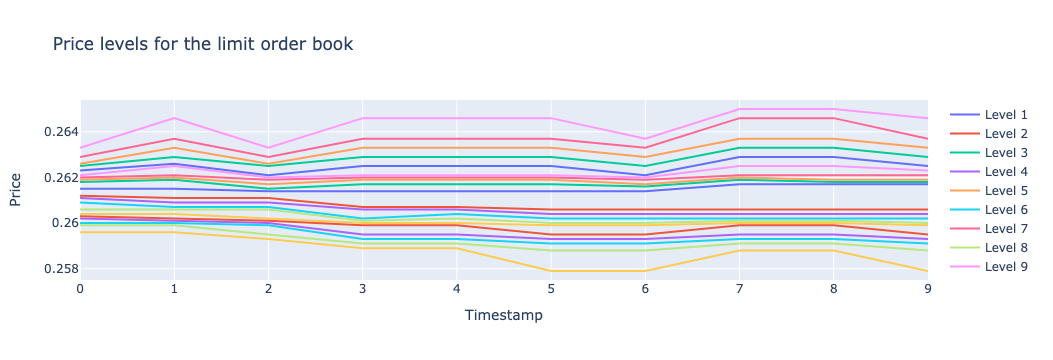

In [31]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()

for col_index, col_values in enumerate(a_b_df["samples"].transpose()):
    fig.add_trace(go.Scatter(x=a_b_df.index, y=col_values, mode='lines', name=f'Level {col_index + 1}'))

fig.update_layout(title='Price levels for the limit order book', xaxis_title='Timestamp', yaxis_title='Price')
fig.show()
